In [9]:
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

color_palette = [sns.color_palette()[0], sns.color_palette()[3], sns.color_palette()[2], sns.color_palette()[1], sns.color_palette()[4]]
sns.set_palette(color_palette)


net_type = ["spinn","pfnn"][0]
lmbd_start = 2.0
mu_start = 0.3
iteration = 100000
time = [2, False][1]
nDIC = 100
noise = [0, None][1]
run_number = 0

if noise == None:
    run = f"{net_type}_lmbd-{lmbd_start}_mu-{mu_start}_nDIC-{nDIC}_{time if time else iteration}{'min' if time else 'iter'}{f"-{run_number}" if run_number else ''}"    
else:
    run = f"{net_type}_lmbd-{lmbd_start}_mu-{mu_start}_nDIC-{nDIC}_noise-{noise}_{time if time else iteration}{'min' if time else 'iter'}{f"-{run_number}" if run_number else ''}"    

run_folder = f"./results_inverse/{run}/"

print(f"loading {run}")

with open(run_folder + "config.json") as f:
    run_config = json.load(f)

def read_data_file(filename):
    with open(filename, "r") as f:
        # Read the file and split each line
        steps = []
        values = []
        for line in f.readlines():
            step, value = line.strip().split(' ',1)
            steps.append(eval(step))
            values.append(eval(value))


    return steps, values

def moving_average(arr, window_size):
    window = np.ones(window_size)/window_size
    return np.apply_along_axis(lambda x: np.convolve(x, window, mode='valid'), 0, arr)

def moving_min(arr, window_size):
    new_arr = np.zeros((arr.shape[0] - window_size + 1, arr.shape[1]))
    for n_metric in range(arr.shape[1]):
        for i in range(new_arr.shape[0]):
            new_arr[i, n_metric] = np.min(arr[i:i+window_size, n_metric])
    return new_arr
    
loss_history = np.loadtxt(run_folder + "loss_history.dat")
loss_history_mean = moving_average(loss_history, 20)
loss_history_min = moving_min(loss_history, 20)
variables_history =  read_data_file(run_folder + "variables_history.dat")

residuals = loss_history[:, -1]
PDE_loss = np.mean(loss_history[:, 1:3], axis=1)
Mat_loss = np.mean(loss_history[:, 3:5], axis=1) 
DIC_loss = np.mean(loss_history[:, 5:7], axis=1)
steps_loaded = loss_history[:, 0]
lambda_history = np.array(variables_history[1])[:len(steps_loaded),0]#*run_config["variable_training_factor"]
mu_history = np.array(variables_history[1])[:len(steps_loaded),1]#*run_config["variable_training_factor"]

metrics = [residuals, PDE_loss, Mat_loss, DIC_loss]
metrics_names = ["Relative MSE", "PDE Loss", "Material Loss", "DIC Loss"]

# fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# ax.plot(loss_history[:, 0], loss_history[:, -1], loss_history_min[:, 0], loss_history_min[:, -1], loss_history_mean[:, 0], loss_history_mean[:, -1])
# ax.set_yscale('log')

loading spinn_lmbd-2.0_mu-0.3_nDIC-100_100000iter


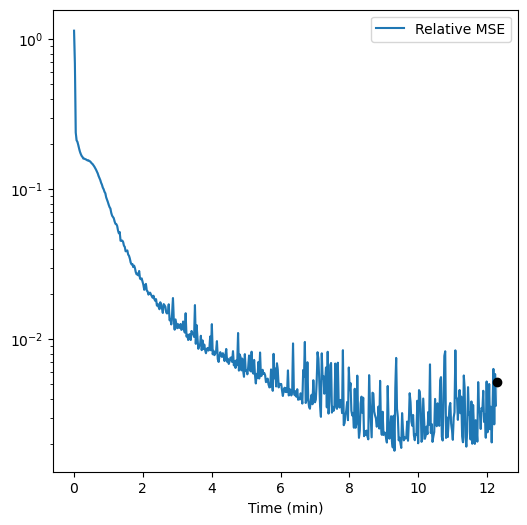

In [10]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation


step_type = ["iteration", "time"][1]
time_unit = ["s", "min"][1]
metrics_idx = [0]#, 1, 2, 3]

t_elapsed = run_config["elapsed"]
if step_type == "time":
    steps = np.array(steps_loaded) * t_elapsed/steps_loaded[-1]
    if time_unit == "min":
        steps = steps/60
else:
    steps = steps_loaded

def init_metrics(ax, metrics_idx=[0]):
    ax.set_yscale('log')
    lines = []
    scatters = []
    for idx in metrics_idx:
        ax.plot(steps, metrics[idx], alpha=0.2, color=color_palette[idx])
        lines.append(ax.plot([], [], zorder=3, color=color_palette[idx], label=metrics_names[idx])[0])
        scatters.append(ax.scatter([], [], c='k', zorder=4))


    # line_pinn, = ax.plot([], [], color=color_palette[0], zorder=3)
    # ax.plot(steps, residuals, color=color_palette[0], alpha=0.2)
    # scatter_pinn = ax.scatter([], [], c='k', zorder=4)
    ax.legend()
    # ax.set_ylabel("Mean residual")
    if step_type == "time":
        ax.set_xlabel(f"Time ({time_unit})")
    else:
        ax.set_xlabel("Iterations")
    return lines, scatters

def update_metrics(iterations, lines, scatters, metrics_idx=[0]):

    for line, scatter, metric_idx in zip(lines, scatters, metrics_idx):
        line.set_data(steps[:iterations], metrics[metric_idx][:iterations])
        scatter.set_offsets([steps[iterations], metrics[metric_idx][iterations]])

    return lines, scatters

fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=100)
lines, scatters = init_metrics(ax,  metrics_idx=metrics_idx)
update_metrics(-1, lines, scatters, metrics_idx=metrics_idx)
plt.show()

# anim = animation.FuncAnimation(fig, update_losshistory, fargs=(line_pinn, line_spinn, scatter_pinn, scatter_spinn), frames=int(len(losshistory_pinn)/10), interval=100, repeat=False)
# HTML(anim.to_jshtml())

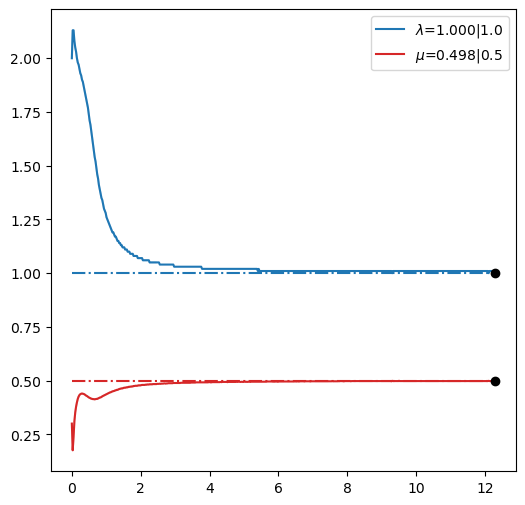

In [11]:
lambda_actual = run_config["lmbd_actual"]
mu_actual = run_config["mu_actual"]

def init_variables(ax):
    ax.hlines(y=lambda_actual,xmin=0, xmax=steps.max(), linestyles='-.', colors=color_palette[0])#, label=r"Actual $\lambda=$"+f"{lambda_actual}")
    ax.hlines(y=mu_actual,xmin=0, xmax=steps.max(), linestyles='-.', colors=color_palette[1])#, label=r"Actual $\mu=$"+f"{mu_actual}")
    line_lambda, = ax.plot([], [], color=color_palette[0], zorder=3, label=r"$\lambda$"+f"={lambda_history[0]:.3f}|{lambda_actual}")
    line_mu, = ax.plot([], [], color=color_palette[1], zorder=3,label=r"$\mu$"+f"={mu_history[0]:.3f}|{mu_actual}")
    ax.plot(steps[:100], lambda_history[:100], color=color_palette[0], alpha=0.2)
    ax.plot(steps[:100], mu_history[:100], color=color_palette[1], alpha=0.2)
    scatter_mu = ax.scatter([], [], c='k', zorder=4)
    scatter_lambda = ax.scatter([], [], c='k', zorder=4)

    ax.legend()
    # if step_type == "time":
    #     ax.set_xlabel(f"Time ({time_unit})")
    # else:
    #     ax.set_xlabel("Iterations")
    return line_lambda, line_mu, scatter_mu, scatter_lambda, ax

def update_variables(iterations, line_lambda, line_mu, scatter_mu, scatter_lambda,ax):

    line_lambda.set_data(steps[:iterations], lambda_history[:iterations])
    line_lambda.set_label(r"$\lambda$"+f"={lambda_history[iterations]:.3f}|{lambda_actual}")
    scatter_lambda.set_offsets([steps[iterations], lambda_history[iterations]])
    line_mu.set_data(steps[:iterations], mu_history[:iterations])
    line_mu.set_label(r"$\mu$"+f"={mu_history[iterations]:.3f}|{mu_actual}")
    scatter_mu.set_offsets([steps[iterations], mu_history[iterations]])
    ax.legend()
    return line_lambda, line_mu, scatter_mu, scatter_lambda, ax

fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=100)
line_lambda, line_mu, scatter_mu, scatter_lambda,ax = init_variables(ax)
update_variables(-1, line_lambda, line_mu, scatter_mu, scatter_lambda, ax)
plt.show()


In [12]:
logged_field = run_config["logged_fields"]
field_names = list(logged_field.values())
fields_id = [0,1,2,3,4][:2] #{0: "Ux", 1: "Uy", 2: "Sxx", 3: "Syy", 4: "Sxy"}

X_DIC = np.stack([run_config["x_DIC"], run_config["y_DIC"]], axis=1)

fields = [None]*5
for field_id in fields_id:
    field_name = logged_field[str(field_id)]
    _, V_pinn = read_data_file(run_folder + f"{field_name}_history.dat")
    fields[field_id] = np.array(V_pinn)

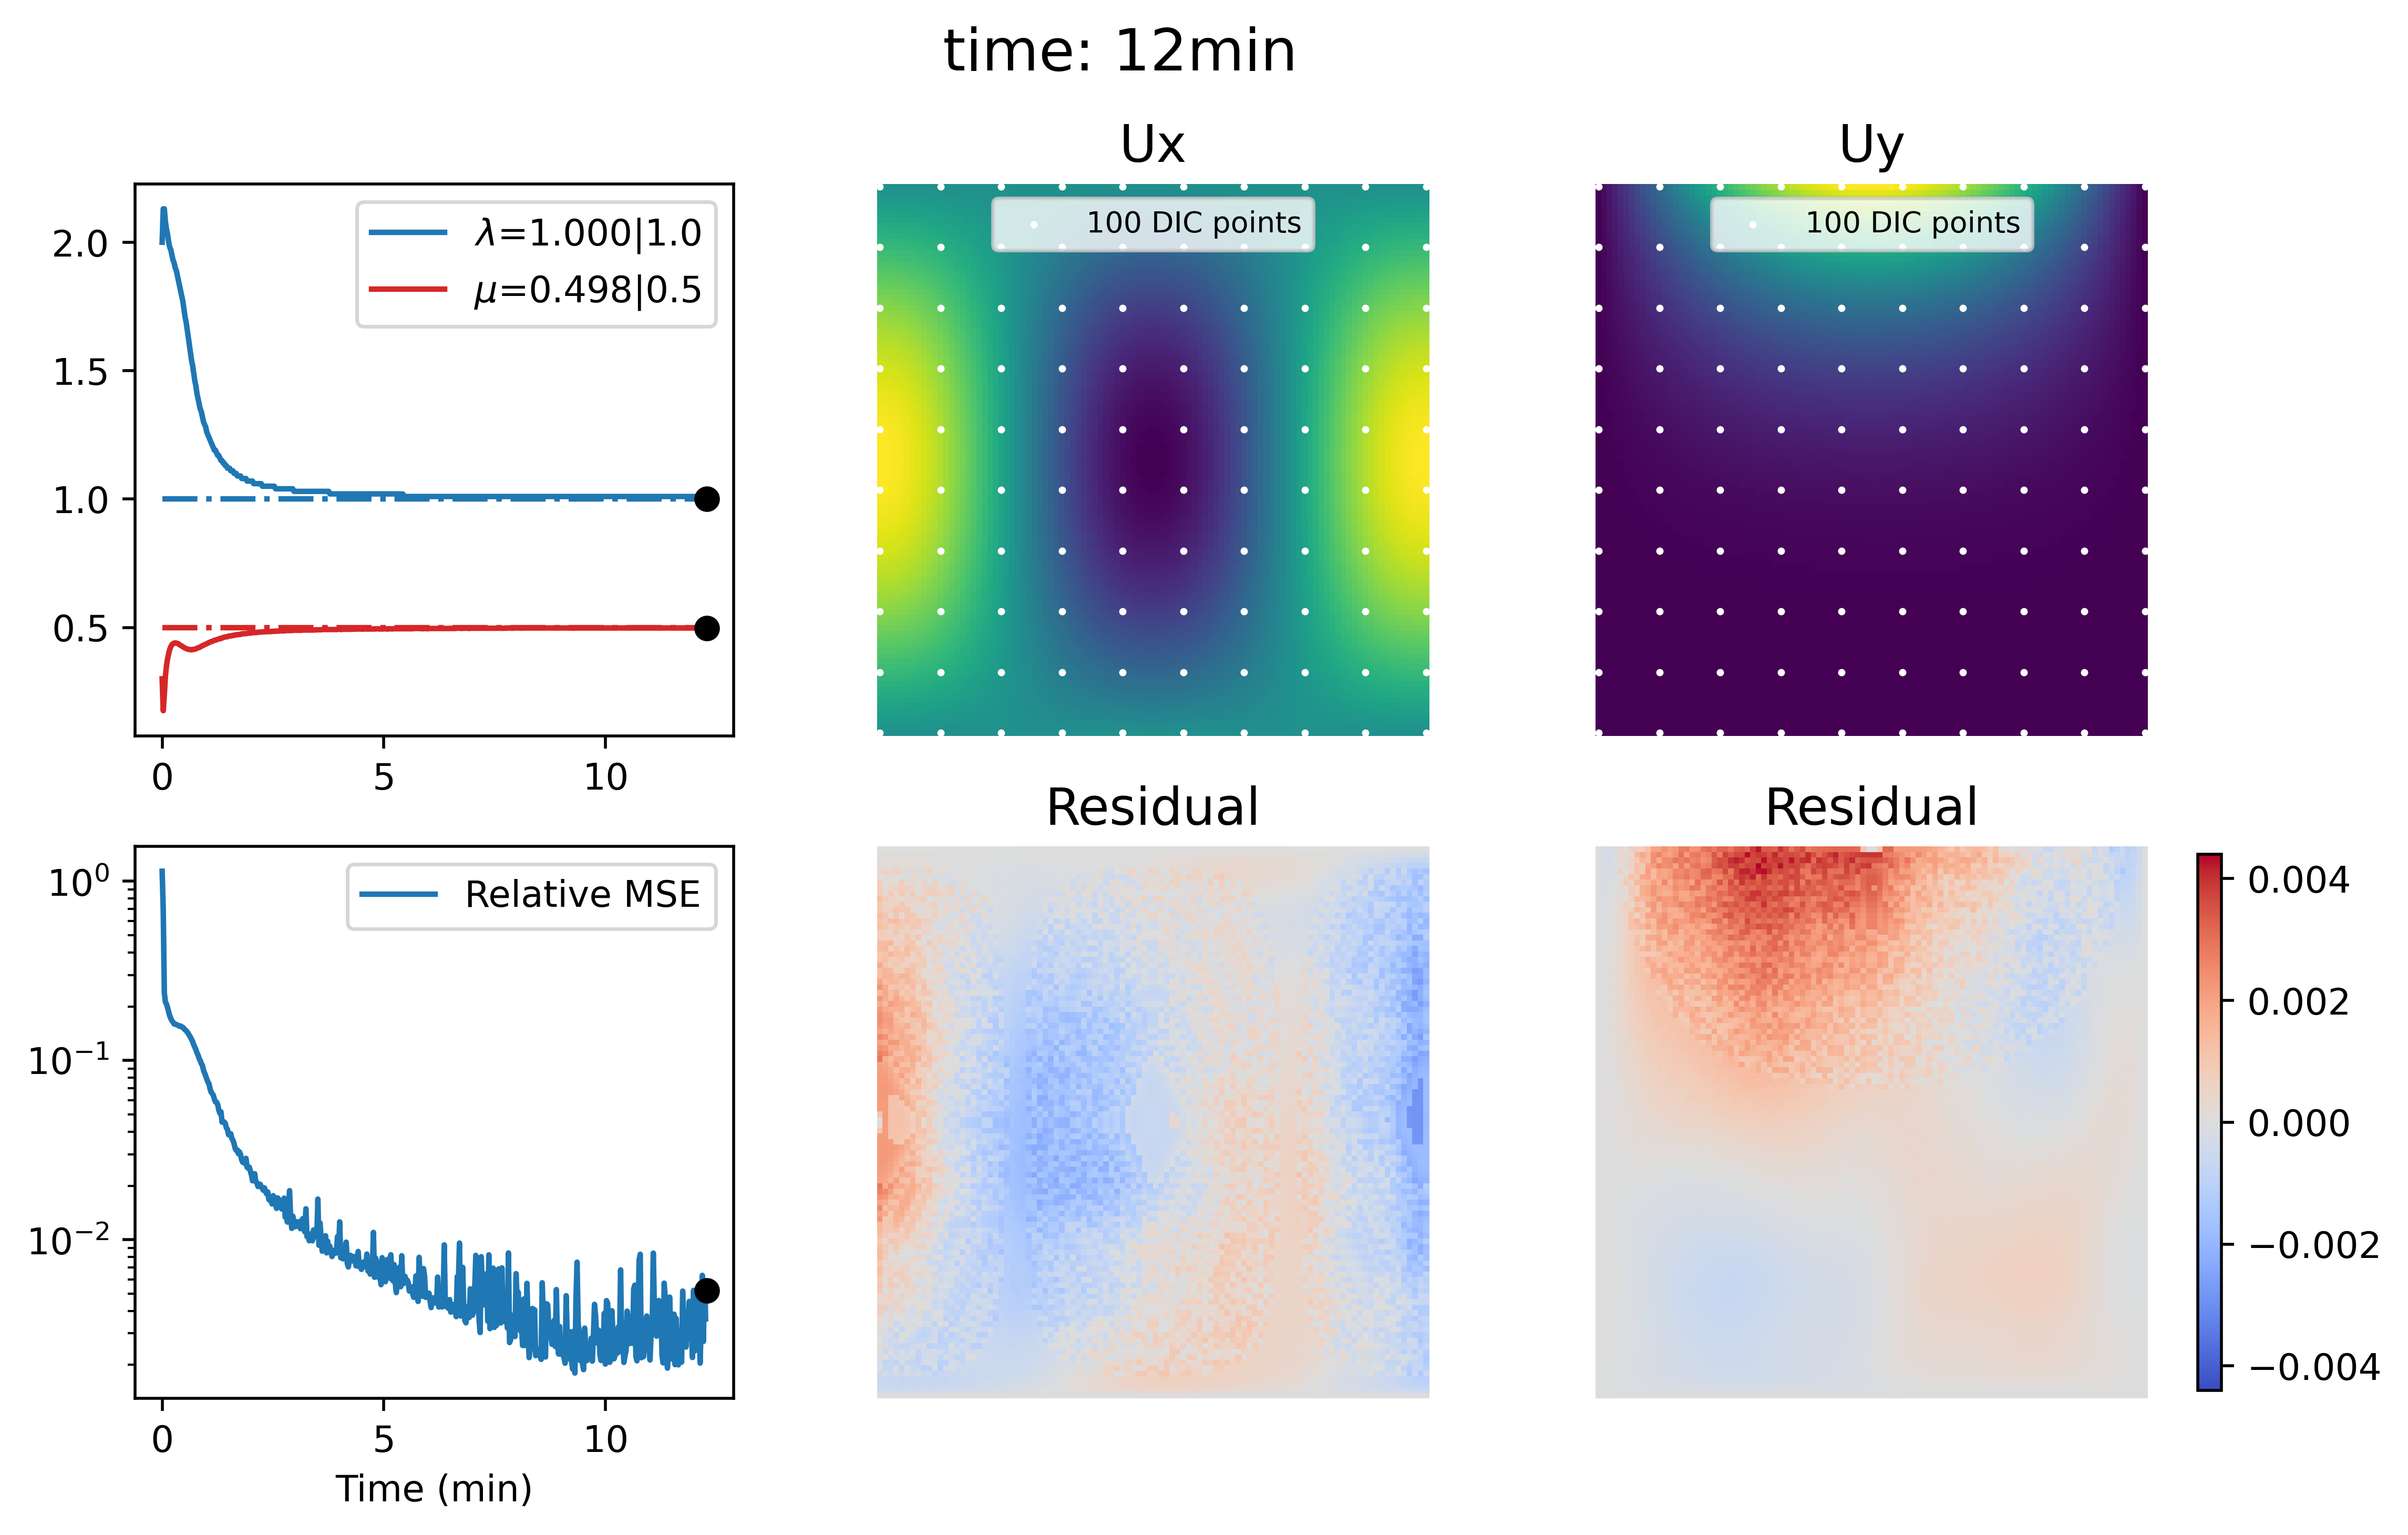

In [13]:
import matplotlib.colors as colors

fields_id = [0,1,2,3,4][:2] #{0: "Ux", 1: "Uy", 2: "Sxx", 3: "Syy", 4: "Sxy"}
n_fields = len(fields_id)

lmbd = 1.0
mu = 0.5
Q = 4.0

def func(x):

    ux = np.cos(2 * np.pi * x[:, 0:1]) * np.sin(np.pi * x[:, 1:2])
    uy = np.sin(np.pi * x[:, 0:1]) * Q * x[:, 1:2] ** 4 / 4

    E_xx = -2 * np.pi * np.sin(2 * np.pi * x[:, 0:1]) * np.sin(np.pi * x[:, 1:2])
    E_yy = np.sin(np.pi * x[:, 0:1]) * Q * x[:, 1:2] ** 3
    E_xy = 0.5 * (
        np.pi * np.cos(2 * np.pi * x[:, 0:1]) * np.cos(np.pi * x[:, 1:2])
        + np.pi * np.cos(np.pi * x[:, 0:1]) * Q * x[:, 1:2] ** 4 / 4
    )

    Sxx = E_xx * (2 * mu + lmbd) + E_yy * lmbd
    Syy = E_yy * (2 * mu + lmbd) + E_xx * lmbd
    Sxy = 2 * E_xy * mu

    return np.hstack((ux, uy, Sxx, Syy, Sxy))

def pcolor_plot(AX, X, Y, C, title,colormap="viridis",norm=None):
    im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto',norm=norm)
    AX.axis("equal")
    AX.axis("off")
    AX.set_title(title, fontsize=14)
    return im

def plot_field(i, fields, field_id, Xmesh, Ymesh, func, X_DIC, ax, plot_DIC=True):
    field = np.array(fields[field_id][i]).reshape(Xmesh.shape)
    field_exact = func(np.hstack((Xmesh.reshape(-1, 1), Ymesh.reshape(-1, 1))))[:,field_id].reshape(Xmesh.shape)
    field_norm = colors.Normalize(vmin=field_exact.min(), vmax=field_exact.max())
    im = pcolor_plot(ax, Xmesh, Ymesh, field, field_names[field_id], norm=field_norm)
    if plot_DIC:
        ax.scatter(X_DIC[:,0], X_DIC[:,1], c='w', s=1, label=f"{len(X_DIC)} DIC points")
        ax.legend(fontsize=8, loc='upper center')
    return im

def plot_field_residual(i, fields, field_id, Xmesh, Ymesh, func, ax, diff_norm, ngrid=100):
    field_exact = func(np.hstack((Xmesh.reshape(-1, 1), Ymesh.reshape(-1, 1))))[:,field_id].reshape(Xmesh.shape)
    field_diff = np.array(fields[field_id][i]).reshape(Xmesh.shape)-field_exact
    im = pcolor_plot(ax, Xmesh, Ymesh, field_diff, "Residual", colormap="coolwarm", norm=diff_norm)
    return im

def set_normdiff(i, fields, fields_id, func, Xmesh, Ymesh, ngrid=100):
    fields_exact = func(np.hstack((Xmesh.reshape(-1, 1), Ymesh.reshape(-1, 1))))

    cmaxs = []  
    cmins = []
    for field_id in fields_id:
        diff = np.array(fields[field_id][i]).reshape(-1,ngrid,ngrid)-fields_exact[:,field_id].reshape(ngrid,ngrid)
        abs_diff = np.abs(diff)
        cmax = abs_diff.max() if diff.max() > 0 else 0
        cmin = -abs_diff.max() if diff.min() < 0 else 0
        cmaxs.append(cmax)
        cmins.append(cmin) 
    normdiff = colors.Normalize(vmin=-1, vmax=1)
    normdiff.vmin = min(cmins)
    normdiff.vmax = max(cmaxs)
    return normdiff

iter = -1
ngrid = 100
field_id = 0


Xmesh, Ymesh = np.meshgrid(np.linspace(0, 1, ngrid), np.linspace(0, 1, ngrid), indexing='ij')
normdiff = set_normdiff(iter, fields, fields_id, func, Xmesh, Ymesh)

fig, ax = plt.subplots(2,1+n_fields,figsize = (4+n_fields*3,6),dpi = 500)#50+50*n_fields)

line_lambda, line_mu, scatter_mu, scatter_lambda, ax_variables = init_variables(ax[0][0])
update_variables(iter, line_lambda, line_mu, scatter_mu, scatter_lambda, ax_variables)

lines, scatters = init_metrics(ax[1][0])
lines, scatters = update_metrics(iter, lines, scatters)
ims_field = []
ims_res = []
for i, field_id in enumerate(fields_id):
    ims_field.append(plot_field(iter, fields, field_id, Xmesh, Ymesh, func, X_DIC, ax[0][i+1], plot_DIC=field_id<2))
    ims_res.append(plot_field_residual(iter, fields, field_id, Xmesh, Ymesh, func, ax[1][i+1], normdiff))

cax = fig.add_axes([0.91, 0.115, 0.009, 0.34])
cbdiff = fig.colorbar(ims_res[0], cax=cax)

fig.suptitle(f"{step_type}: {steps[iter]:.0f}{f"{time_unit}" if step_type == "time" else ""}", fontsize=16)
plt.tight_layout
plt.show()

    

In [14]:
import matplotlib.animation as animation
from IPython.display import HTML
from itertools import chain

def animate(i, ims_field, ims_res, line_lambda, line_mu, scatter_mu, scatter_lambda, ax_variables, lines, scatters):

    step = int(steps[i])

    fig.suptitle(f"{step_type}: {steps[i]:.0f}{f"{time_unit}" if step_type == "time" else ""}", fontsize=16)

    line_lambda, line_mu, scatter_mu, scatter_lambda ,ax_variables = update_variables(i, line_lambda, line_mu, scatter_mu, scatter_lambda, ax_variables)
    lines, scatters = update_metrics(i, lines, scatters)
    
    normdiff = set_normdiff(i, fields, fields_id, func, Xmesh, Ymesh)

    for im_field, im_res, field_id in zip(ims_field, ims_res, fields_id):
        field = np.array(fields[field_id][i]).reshape(Xmesh.shape)
        field_exact = func(np.hstack((Xmesh.reshape(-1, 1), Ymesh.reshape(-1, 1))))[:,field_id].reshape(Xmesh.shape)
        field_diff = field-field_exact

        im_field.set_array(field)
        im_res.set_array(field_diff)
        im_res.set_norm(normdiff)
    
    cbdiff.update_normal(ims_res[-1])

    return ims_field, ims_res, line_lambda, line_mu, scatter_mu, scatter_lambda, ax_variables, lines, scatters

def subsample_steps(steps, sub_factors):
    section_ends = [int(len(steps)*i/len(sub_factors)) for i in range(1, len(sub_factors)+1)]
    frame_steps_lists = []
    for i, step_size in enumerate(sub_factors):
        start = section_ends[i-1] if i > 0 else 0
        end = section_ends[i]
        frame_steps_lists.append(range(start, end, step_size))
    frame_steps = chain.from_iterable(frame_steps_lists)
    return frame_steps


all_steps = list(range(len(steps)))
sub_factors = [2] + [4]*2 #list(range(1,4)) + [4]*5 #slower at the beginning
frame_steps = list(subsample_steps(all_steps, sub_factors))

anim = animation.FuncAnimation(fig, animate, fargs=(ims_field, ims_res, line_lambda, line_mu, scatter_mu, scatter_lambda, ax_variables, lines, scatters), frames=frame_steps, interval=100, repeat=False)

fps = 10
print("Video duration: ", len(frame_steps)/fps, "s")
# HTML(anim.to_jshtml())

Video duration:  16.8 s


In [426]:
video_name = f"{"-".join([field_names[field_id] for field_id in fields_id])}_{step_type}"
video_path = f"{run_folder}{video_name}"
anim.save(f"{video_path}.mp4", writer='ffmpeg', fps=10)
print(f"Video saved at {video_path}.mp4")

Video saved at ./results/spinn_lmbd-2.0_mu-0.3_nDIC-100_100000iter/Sxx-Syy-Sxy_time.mp4


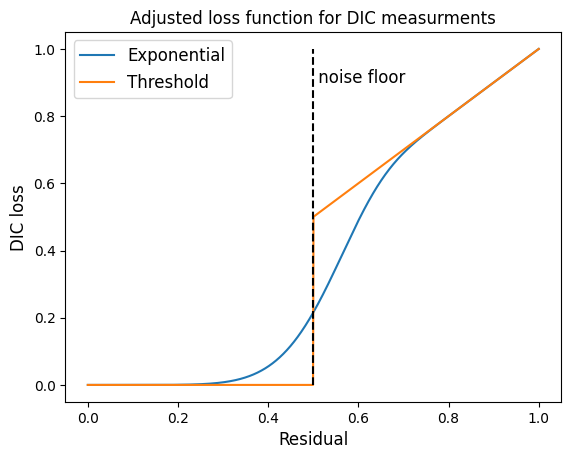

In [29]:
#exponential decay
max_range = 1
noise_floor = max_range/2
dist = np.linspace(0, max_range, 1000)

def exponential_loss(dist, noise_floor):
    return dist*(1-np.exp(-(dist/(1.1*noise_floor))**6))
def threshold_loss(dist, noise_floor):
    return np.where(np.abs(dist)<noise_floor, 0, dist)
# plt.figure(size=(8,6))
plt.plot(dist, exponential_loss(dist, noise_floor), label="Exponential")
plt.plot(dist, threshold_loss(dist, noise_floor), label="Threshold")
# plt.plot(dist, dist, 'k--')
plt.vlines(noise_floor, 0, max_range, linestyles='--',colors='k')
plt.text(noise_floor, max_range*0.9, f" noise floor", color='k', fontsize=12)
plt.title("Adjusted loss function for DIC measurments")
plt.xlabel("Residual", fontsize=12)
plt.ylabel("DIC loss", fontsize=12)
plt.legend(fontsize=12)
